<a href="https://colab.research.google.com/github/MinyoungHer/Pytorch-study/blob/main/Pytorch_custom_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 04. Pytorch Custom Datasets Video Notebook

We've used some datasets with Pytorch before.

But how do u get ur own data into Pytorch?

## Domain libraries

Depending on what you're working on, you'll want to look into each of Pytorch domain libraries for existing data loading functions and customizable data loading functions.

One of the waus to do is via: custom datasets

##0.Importing Pytorch and setting up device-agnostic code

In [1]:
import torch
from torch import nn

# Note: pytorch 1.10.0+ is required for this course
torch.__version__

'2.0.1+cu118'

In [2]:
# Set up device-agnostic code
device="cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

##1. Get data

Our dataset is a subset of Food101 dataset.

Food101 starts 3 different classes of food and 100 images per class

75 training, 25 testing

In [3]:
import requests
import zipfile
from pathlib import Path

# Setup path to a data folder
data_path=Path("data/")
image_path=data_path/"pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
  print(f"{image_path} directory already exists... skipping download")
else:
  print(f"{image_path} deos not exist, creating one...")
  image_path.mkdir(parents=True, exist_ok=True)

# Download pizza, steak and sushi data
with open(data_path/"pizza_steak_sushi.zip","wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print("Downloading pizza, steak, sushi data...")
  f.write(request.content)

# Unzip
with zipfile.ZipFile(data_path/ "pizza_steak_sushi.zip", "r") as zip_ref:
  print("Unzipping the data")
  zip_ref.extractall(image_path)

data/pizza_steak_sushi deos not exist, creating one...
Unzipping the data


##2. Becoming one with the data (data preparation and data exploration)

In [4]:
import os
def walk_through_dir(dir_path):
  """Walks through dir_path returning its contents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}.")

In [5]:
walk_through_dir(image_path)

There are 2 directories and 0 images in data/pizza_steak_sushi.
There are 3 directories and 0 images in data/pizza_steak_sushi/test.
There are 0 directories and 25 images in data/pizza_steak_sushi/test/pizza.
There are 0 directories and 31 images in data/pizza_steak_sushi/test/sushi.
There are 0 directories and 19 images in data/pizza_steak_sushi/test/steak.
There are 3 directories and 0 images in data/pizza_steak_sushi/train.
There are 0 directories and 78 images in data/pizza_steak_sushi/train/pizza.
There are 0 directories and 72 images in data/pizza_steak_sushi/train/sushi.
There are 0 directories and 75 images in data/pizza_steak_sushi/train/steak.


In [6]:
# setup train and testing paths
train_dir = image_path / "train"
test_dir=image_path/"test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

## 2.1 Visualizing and image

write some code to:
1. Get all of the image paths
2. Pick a random image path using Python's random.choice()
3. Get the image class name using `pathlib.Path.parent.stem`
4. Since we're working with images, let's open the image with Python PIL
5. We'll then show the image and print metadata

Random image path: data/pizza_steak_sushi/train/steak/1787505.jpg
Image class: steak
Image height: 512
Image width: 512


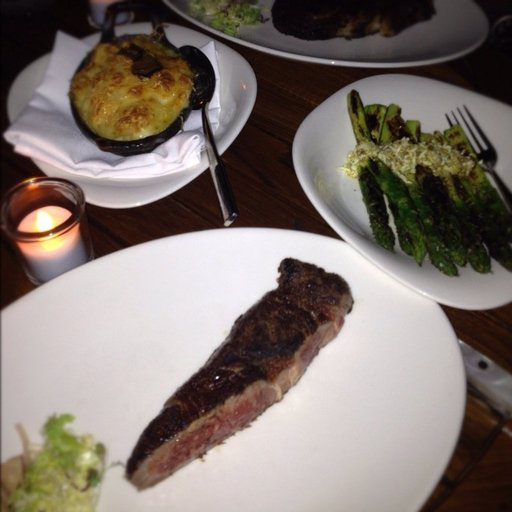

In [7]:
import random
from PIL import Image

# Set seed
#random.seed(42)

# 1. Get all image paths
image_path_list=list(image_path.glob("*/*/*.jpg"))

# 2. Pick a random image path
random_image_path=random.choice(image_path_list)


# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class=random_image_path.parent.stem


# 4. Open image
img=Image.open(random_image_path)

#5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

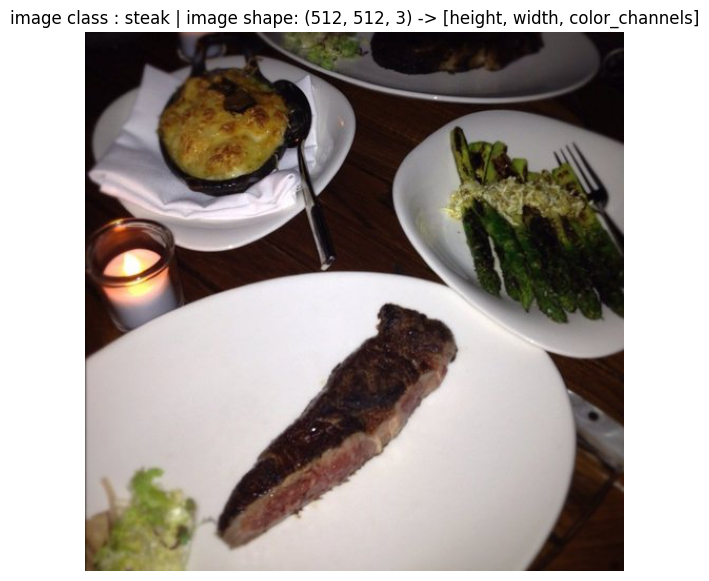

In [8]:
# Try to visualize and image with matplotlib
import numpy as np
import matplotlib.pyplot as plt

# Turn  the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.title(f"image class : {image_class} | image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);

##3. Transforming data

get data to tensor format
1. Turn your target data into tensors (in our case, numerical representation of our images).
2. Turn it into a `torch.utils.data.Dataset` and subsequently a `toch.utils.data.DataLoader`, we'll call these `Dataset` and `DataLoader`


In [9]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### 3.1 Transforming data with `torchvision.transforms`

Transforms help you get your images ready to be used with a model/perform data augmetnation

In [10]:
# Write a transform for iamge
data_transform = transforms.Compose([
    # Resize our images to 64x64
    transforms.Resize(size=(64,64)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5),
    # Turn the image into a torch.Tensor
    transforms.ToTensor()
])

In [11]:
data_transform(img).shape

torch.Size([3, 64, 64])

In [12]:
def plot_transformed_iamges(image_paths:list, transform, n=3, seed=42):
  """
  Selects random images from a path of images and loads/transfroms them then plots the orivinal vs transformed version
  """
  if seed:
    random.seed(seed)
  random_image_paths=random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax=plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nSize: {f.size}")
      ax[0].axis(False)

      # Transform and plot the target image
      transformed_iamge=transform(f).permute(1,2,0) # note we we will need to change shape for matplotlib (H,W,C)
      ax[1].imshow(transformed_iamge)
      ax[1].set_title(f"Transformed\nSize: {transformed_iamge.shape}")
      ax[1].axis("off")

      fig.suptitle(f"class: {image_path.parent.stem}", fontsize=16)




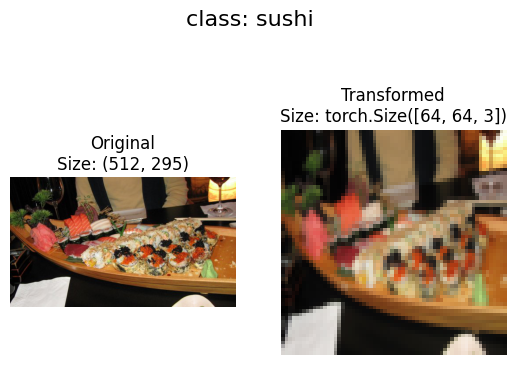

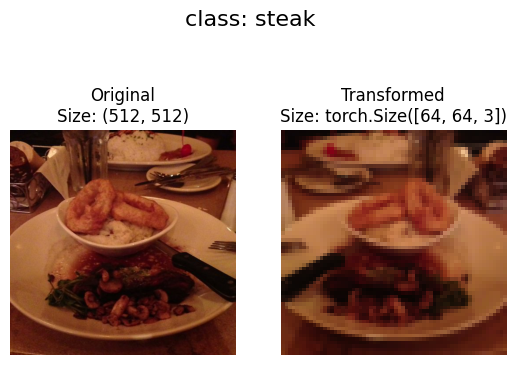

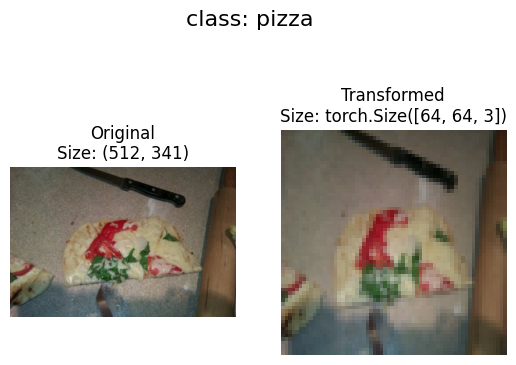

In [13]:
plot_transformed_iamges(image_paths=image_path_list,
                        transform=data_transform,
                        n=3,
                        seed=None)

## 4. Option 1: Loading image data using `ImageFolder`

We can load image classification data using `torchvision.datasets.ImageFolder`


In [14]:
# Use ImageFolder to create datasets
from torchvision import datasets
train_data=datasets.ImageFolder(root=train_dir,
                                transform=data_transform, # a transform for the data
                                target_transform=None) # a transform for the label/target

test_data=datasets.ImageFolder(root=test_dir,
                               transform=data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [15]:
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [16]:
# Get class names
class_names=train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [17]:
# Get class names as dict
class_dict=train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [18]:
# Check the lengths of our dataset
len(train_data), len(test_data)

(225, 75)

In [19]:
# Index on the train_data dataset to get a single image and label
img, label=train_data[0][0], train_data[0][1]
print(f"Image tensor : \n {img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor : 
 tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
         [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
         [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
         ...,
         [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
         [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0863],
         [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],

        [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
         [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0706],
         [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
         ...,
         [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
         [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
         [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],

        [[0.0196, 0.0196, 0.0196,  ..., 0.0902, 0.0902, 0.0941],
         [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
         [0.0196, 0.0157, 0.0157,  ..., 0

Original shape: torch.Size([3, 64, 64]) -> [C,H,W]
Image permute : torch.Size([64, 64, 3]) -> H,W,C


Text(0.5, 1.0, 'pizza')

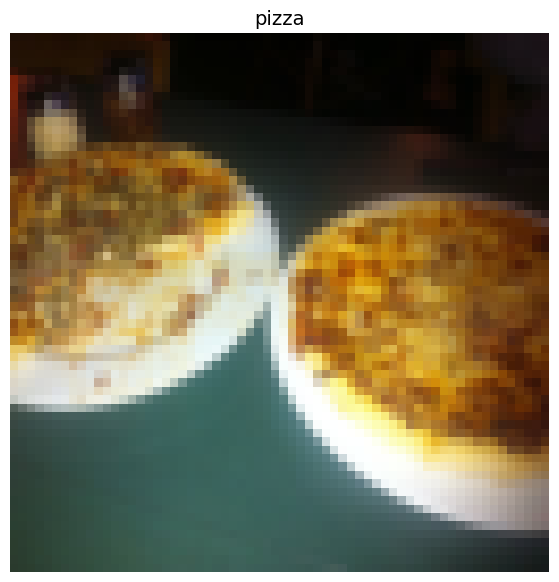

In [20]:
# Rearrange the order dimensions
img_permute=img.permute(1,2,0)

# Print out different shapes
print(f"Original shape: {img.shape} -> [C,H,W]")
print(f"Image permute : {img_permute.shape} -> H,W,C")

# Plot the image
plt.figure(figsize=(10,7))
plt.imshow(img_permute)
plt.axis("off")
plt.title(class_names[label], fontsize=14)

## 4.1 Turn loaded iamges into `DataLoader`s

is going to help us turn our `Dataset`s into iterables and we can customize the `batch_size` so our model can see `batch_size` images at a time

In [21]:
# Turn train and test datasets into dataloader's
from torch.utils.data import DataLoader
BATCH_SIZE=1
train_dataloader=DataLoader(dataset=train_data,
                            batch_size=BATCH_SIZE,
                            num_workers=os.cpu_count(),
                            shuffle=True)

test_dataloader=DataLoader(dataset=test_data,
                           batch_size=BATCH_SIZE,
                           num_workers=os.cpu_count(),
                           shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7fe30e12b220>,
 <torch.utils.data.dataloader.DataLoader at 0x7fe30df4f490>)

len(train_data), len(test_data)

In [22]:
img, label=next(iter(train_dataloader))

# You can change the Batch size
print(f"Image shape: {img.shape} --> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64]) --> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


## 5. Option 2: Loading Image Data with a Custom `Dataset`

1. load images from file
2. get class names from the Dataset
3. get classes as dictionary from the Dataset



In [23]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List


In [24]:
# Instance of torchvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

## 5.1 Creating a helper function to get class names

We want a function to:
1. Get the class names using `os.scandir()` to traverse a target directory (ideally the directory is in standard image classification format).
2. Raise an error if the class names aren't found (if this happens, there might be something wrong with the directory structure).
3. Turn the class names into a dict and a list and return them.

In [25]:
# Setup path for target directory
target_directory=train_dir
print(f"target dir: {target_directory}")

# Get the class names from the target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found

target dir: data/pizza_steak_sushi/train


['pizza', 'steak', 'sushi']

In [26]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
  """Finds the classes folder names in a target directory."""
  # 1. Get the class names by scanning the target directory
  classes=sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
  # 2. Raise an error if class names could not be found
  if not classes:
    raise FileNotFoundError(f"Couldn't find any classes in {directory}")

  #3. Create a dictionary of index labels
  class_to_idx={class_name: i for i, class_name in enumerate(classes)}
  return classes, class_to_idx

In [27]:
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.2 Create a custom `Dataset` to replicate `ImageFolder`

To create our own custom dataset, we want to:

1. subclass `torch.utils.data.Dataset`
2. Init our subclass with a target directory(the directory we'd like to get data form) as well as a transform if we'd like to transform our data.
3. Create several attributes:
 * paths - paths of our images
 * transform- the transform we'd like to use
 * classes - a list of the target classes mapped to integer labels
 * class_to_idx - a dict of the target classes mapped to integer labels
4. Create a function to `load_images()`, this function will open an image
5. Overwrite the `__len()__` method to return the length of our dataset
6. Overwrite the `__getitem()__` method to return a given sample when passed an index


In [28]:
# 0. Write a custom dataset class
from torch.utils.data import Dataset

# 1. Subclass
class ImageFolderCustom(Dataset):
  # 2. Initialize
  def __init__(self, targ_dir: str, transform=None):
    # 3. Create class attributes
    # get all of the image paths
    self.paths=list(pathlib.Path(targ_dir).glob("*/*.jpg"))
    # Setup transforms
    self.transform= transform
    # Create classes and class_to_idx
    self.classes, self.class_to_idx=find_classes(targ_dir)

  #4. Create a function to load images
  def load_image(self, index: int) -> Image.Image:
    " Opens an image via a path and returns it."
    image_path=self.paths[index]
    return Image.open(image_path)

  # 5. Overwrite __len__()
  def __len__(self) -> int:
    "Returns the total number of samples."
    return len(self.paths)

  #6. Overwrite __getitem__() method to return a particular sample
  def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
    " Returns one sample of data, and label(x,y)."
    img=self.load_image(index)
    class_name=self.paths[index].parent.name # expects path in format: data_folder/class_name/image.jpg
    class_idx=self.class_to_idx[class_name]

    # Transform if necessary
    if self.transform:
      return self.transform(img), class_idx # return data, label(X,y)
    else:
      return img, class_idx # return untransformed image and label


In [29]:
# Create a transform
from torchvision.transforms import transforms
train_transforms=transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])
test_transforms=transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor
])

In [30]:
train_data_custom=ImageFolderCustom(targ_dir=train_dir,
                                    transform=train_transforms
                                    )

test_data_custom= ImageFolderCustom(targ_dir=test_dir,
                                    transform=test_transforms)

In [31]:
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x7fe30ddca110>,
 <__main__.ImageFolderCustom at 0x7fe30ddcb880>)

In [32]:
train_data

Dataset ImageFolder
    Number of datapoints: 225
    Root location: data/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )

In [33]:
train_data_custom.classes

['pizza', 'steak', 'sushi']

In [34]:
test_data_custom.classes

['pizza', 'steak', 'sushi']

In [35]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [36]:
# Check for equality between original and ImageFolderCustomDataset
print(train_data_custom.classes==train_data.classes)
print(test_data_custom.classes==test_data.classes)

True
True


### 5.3 Create a function to display random images

1. Take in a `Dataset` and a number of other parameters such as class names and how many images to visualize

2. To prevent the display getting out of hand, let's cap the number of images to see at 10.

3. Set the random seed for reproducibility
4. Get a list of random sample indexes from the target datset.
5. Setup a matplotlib plot.
6. Loop through the random sample images and plot them with matplotlib.
7. Make sure the dimensions of our images line up with matplotlib(HWC)

In [37]:
# 1.
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes:List[str]=None,
                          n:int=10,
                          display_shape: bool = True,
                          seed:int=None):
  #2.
  if n > 10:
    n=10
    display_shape=False
    print(f"For display, n, shouldn't be larger than 10, setting to 10 and removing shape display.")

    #3.
  if seed:
    random.seed(seed)

  #4.
  random_sample_idx=random.sample(range(len(dataset)), k=n)

  #5.
  plt.figure(figsize=(16,8))

  #6.
  for i, targ_sample in enumerate(random_sample_idx):
    targ_image, targ_label=dataset[targ_sample][0], dataset[targ_sample][1]

    #7.
    targ_image_adjust=targ_image.permute(1,2,0)

    plt.subplot(1, n, i+1)
    plt.imshow(targ_image_adjust)
    plt.axis("off")
    if classes:
      title=f"class:{classes[targ_label]}"
      if display_shape:
        title=title+f"\n shape: {targ_image_adjust.shape}"
    plt.title(title)






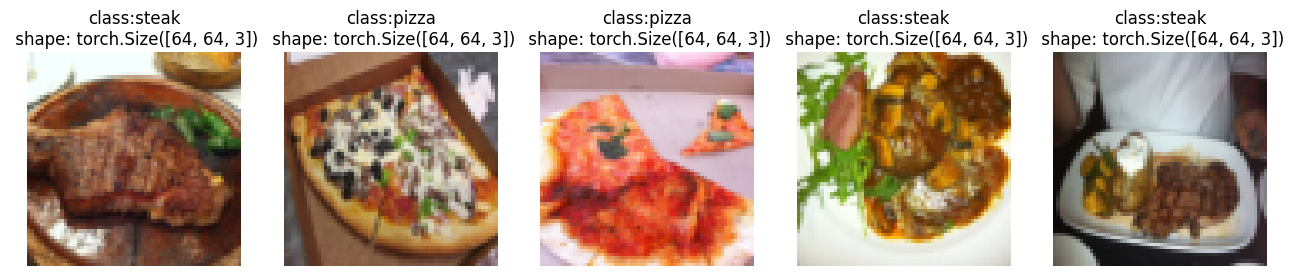

In [38]:
display_random_images(train_data,
                      n=5,
                      classes=class_names,
                      seed=None)

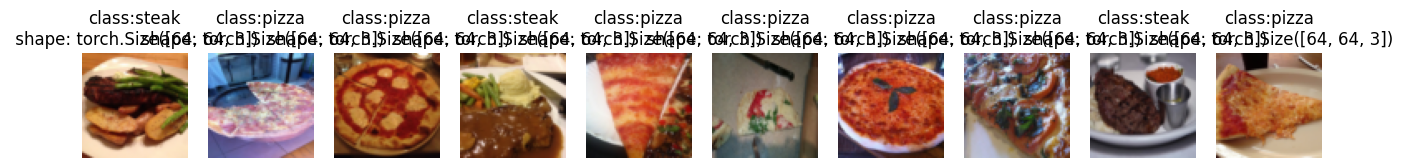

In [39]:
display_random_images(train_data_custom,
                      n=10,
                      classes=class_names,
                      seed=42)

In [40]:
# Turn train and test datasets into dataloader's
from torch.utils.data import DataLoader
BATCH_SIZE=1
train_dataloader_custom=DataLoader(dataset=train_data_custom,
                            batch_size=BATCH_SIZE,
                            num_workers=os.cpu_count(),
                            shuffle=True)

test_dataloader_custom=DataLoader(dataset=test_data_custom,
                           batch_size=BATCH_SIZE,
                           num_workers=os.cpu_count(),
                           shuffle=False)

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x7fe30ced5f60>,
 <torch.utils.data.dataloader.DataLoader at 0x7fe30ced4af0>)

In [41]:
# Get image and label from custom dataloader
img_custom, label_custom=next(iter(train_dataloader_custom))
img_custom.shape, label_custom.shape

(torch.Size([1, 3, 64, 64]), torch.Size([1]))

## 6. Other forms of transforms (data augmentation)

Data augmentation is the process of artificially adding diversity to your training data.

In the case of image data, this mean applying various image transformations to the training images

This practice hopefully results in a model that has unseen data

Let's take a look at one particular type of data augmentation used to train Pytorch vision models to state of art levels...

In [42]:
# trivial augment
from torchvision import transforms
train_transform=transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform=transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.ToTensor()
])

In [43]:
# Get all image paths
image_path_list=list(image_path.glob("*/*/*.jpg"))
image_path_list[:10]

[PosixPath('data/pizza_steak_sushi/test/pizza/398345.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/3475871.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/714866.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/2124579.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/344397.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/195160.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/1925494.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/416067.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/648055.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/2236338.jpg')]

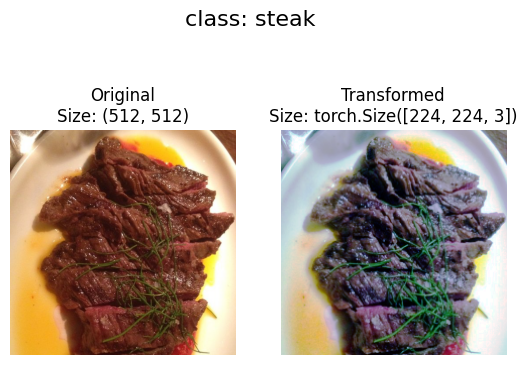

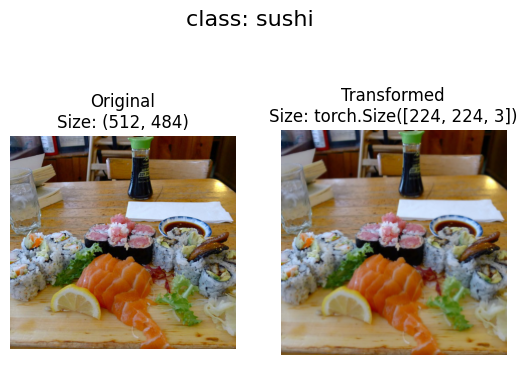

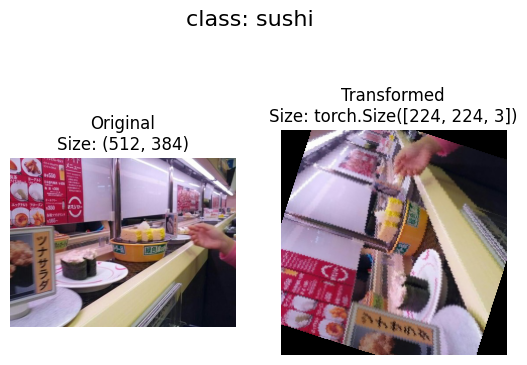

In [44]:
plot_transformed_iamges(
    image_paths=image_path_list,
    transform=train_transform,
    n=3,
    seed=None
)

## 7. Model 0 : TinyVGG without data augmentation

### 7.1 Creating transforms and loading data for Model 0

In [45]:
# Create simple transform

simple_transform=transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

In [46]:
simple_transform

Compose(
    Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)

In [47]:
from torchvision import datasets

train_data_ex=datasets.ImageFolder(root=train_dir,
                                   transform=simple_transform,
                                   target_transform=None
                                  )
test_data_ex=datasets.ImageFolder(root=test_dir,
                                  transform=simple_transform)

In [48]:
import os
from torch.utils.data import DataLoader

In [49]:
Batch_size=32
train_dataloader_ex=DataLoader(dataset=train_data_ex,
                               batch_size=Batch_size,
                               num_workers=os.cpu_count(),
                               shuffle=True)
test_dataloader_ex=DataLoader(dataset=test_data_ex,
                              batch_size=Batch_size,
                              num_workers=os.cpu_count(),
                              shuffle=False)

In [50]:
train_dataloader_ex, test_dataloader_ex

(<torch.utils.data.dataloader.DataLoader at 0x7fe30ced4340>,
 <torch.utils.data.dataloader.DataLoader at 0x7fe30cebb7f0>)

In [51]:
num_workers=os.cpu_count()
num_workers

2

### 7.2 Create TinyVGG model class

In [152]:
from torch.nn.modules.pooling import MaxPool2d
class TinyVGG(nn.Module):
  def __init__(self, input_shape: int,
             hidden_units: int,
             output_shapes: int):
    super().__init__()
    self.conv_block_1=nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),

        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0
                  ),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2)

    )

    self.conv_block_2=nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0
                  ),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2)
    )

    self.classifier=nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*13*13,
                  out_features=output_shapes)
    )
  def forward(self, x):
    x=self.conv_block_1(x)

    x=self.conv_block_2(x)

    x=self.classifier(x)


    return x





In [153]:
torch.manual_seed(42)
model_0=TinyVGG(input_shape=3,
                hidden_units=10,
                output_shapes=len(class_names))
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

### 7.3 Try a forward pass on a singel image

In [154]:
image_batch, label_batch=next(iter(train_dataloader_ex))
image_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [155]:
# Try a forward pass
model_0(image_batch)

tensor([[ 2.0789e-02, -1.9351e-03,  9.5317e-03],
        [ 1.8427e-02,  2.4670e-03,  6.6757e-03],
        [ 1.7699e-02,  1.0262e-03,  9.4657e-03],
        [ 2.4441e-02, -3.3526e-03,  9.6011e-03],
        [ 1.9930e-02,  6.6318e-04,  1.0779e-02],
        [ 2.1281e-02,  2.0434e-03,  5.0046e-03],
        [ 2.0999e-02,  1.2869e-04,  1.2473e-02],
        [ 2.1577e-02, -1.9507e-03,  9.6941e-03],
        [ 2.4504e-02, -4.7745e-03,  8.5280e-03],
        [ 2.0252e-02, -4.7292e-04,  1.0908e-02],
        [ 2.2215e-02, -4.1838e-04,  9.8123e-03],
        [ 2.2313e-02, -2.1622e-03,  9.4456e-03],
        [ 2.1841e-02, -3.7132e-03,  8.3783e-03],
        [ 2.2863e-02, -1.7724e-03,  1.0287e-02],
        [ 2.1647e-02, -4.4139e-03,  9.5022e-03],
        [ 2.2096e-02, -4.1426e-03,  9.3853e-03],
        [ 2.1209e-02, -4.4218e-03,  1.1475e-02],
        [ 2.1711e-02, -2.7656e-03,  8.5006e-03],
        [ 1.9951e-02,  2.8256e-05,  8.4380e-03],
        [ 1.8298e-02,  1.6306e-03,  8.5499e-03],
        [ 2.0768e-02

### 7.4 Use `torchinfo` to get an idea of the shapes going through our model

In [156]:
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo


from torchinfo import summary
summary(model_0, input_size=[1,3,64,64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

In [157]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  # Note: you need the "raw" GitHub URL for this to work
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

helper_functions.py already exists, skipping download


In [158]:
from helper_functions import accuracy_fn

In [159]:
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(params=model_0.parameters(), lr=0.001)

In [160]:
image_batch.shape

torch.Size([32, 3, 64, 64])

In [161]:
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

In [162]:
loss_fn(model_0(image_batch), label_batch)

tensor(1.0958, grad_fn=<NllLossBackward0>)

In [163]:
def training_step(model:torch.nn.Module,
                  data_loader: torch.utils.data.DataLoader,
                  loss_fn: torch.nn.Module,
                  optimizer: torch.optim.Optimizer,
                  ):
  train_loss, train_acc=0,0
  for batch, (X,y) in enumerate(data_loader):
    y_pred=model(X)
    loss=loss_fn(y_pred, y)
    train_loss+=loss.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    y_pred_class=torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc+=(y_pred_class==y).sum().item()/len(y_pred)




  train_loss/=len(data_loader)
  train_acc/=len(data_loader)
  return train_loss, train_acc

def testing_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              ):
  test_loss, test_acc=0,0
  model.eval()
  with torch.inference_mode():
    for (X,y) in data_loader:
      test_pred_logits=model(X)
      loss=loss_fn(test_pred_logits, y)
      test_loss+=loss.item()

      test_pred_labels=test_pred_logits.argmax(dim=1)
      test_acc+=(test_pred_labels==y).sum().item()/len(test_pred_labels)

  test_loss/=len(data_loader)
  test_acc/=len(data_loader)
  return test_loss, test_acc



In [164]:
train_dataloader

In [165]:
training_step(model=model_0,
              data_loader=train_dataloader_ex,
              loss_fn=loss_fn,
              optimizer=optimizer)

(1.1099387258291245, 0.28125)

In [166]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module=nn.CrossEntropyLoss(),
          epochs: int=5,
          ):

  results={"train_loss":[],
           "train_acc":[],
           "test_loss":[],
           "test_acc":[]}

  for epoch in tqdm(range(epochs)):
    train_loss, train_acc=training_step(model=model,
                                        data_loader=train_dataloader,
                                        loss_fn=loss_fn,
                                        optimizer=optimizer
                                       )
    test_loss, test_acc=testing_step(model=model,
                                     data_loader=test_dataloader,
                                     loss_fn=loss_fn)
    print(f"Epoch: {epoch} | train loss {train_loss}, train_acc: {train_acc} | test_loss: {test_loss}, test_acc:{test_acc}")

    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  return results


In [167]:
model_0_results=train(model=model_0,
                      train_dataloader=train_dataloader_ex,
                      test_dataloader=test_dataloader_ex,
                      optimizer=optimizer,
                      loss_fn=loss_fn,
                      epochs=5)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | train loss 1.1000895500183105, train_acc: 0.29296875 | test_loss: 1.145362416903178, test_acc:0.19791666666666666
Epoch: 1 | train loss 1.1187032759189606, train_acc: 0.37890625 | test_loss: 1.1454023122787476, test_acc:0.2604166666666667
Epoch: 2 | train loss 1.0871707499027252, train_acc: 0.42578125 | test_loss: 1.1125946044921875, test_acc:0.2604166666666667
Epoch: 3 | train loss 1.0971160978078842, train_acc: 0.3046875 | test_loss: 1.101880153020223, test_acc:0.2604166666666667
Epoch: 4 | train loss 1.0733202397823334, train_acc: 0.4453125 | test_loss: 1.079183578491211, test_acc:0.3125


### 7.8 Plot the loss curves of model 0

A **loss curves** is a way of tracking your model's progress ovr time.


# Get the model_0 results keys

model_0_results.keys()

In [168]:
model_0_results

{'train_loss': [1.1000895500183105,
  1.1187032759189606,
  1.0871707499027252,
  1.0971160978078842,
  1.0733202397823334],
 'train_acc': [0.29296875, 0.37890625, 0.42578125, 0.3046875, 0.4453125],
 'test_loss': [1.145362416903178,
  1.1454023122787476,
  1.1125946044921875,
  1.101880153020223,
  1.079183578491211],
 'test_acc': [0.19791666666666666,
  0.2604166666666667,
  0.2604166666666667,
  0.2604166666666667,
  0.3125]}

In [169]:
epochs=range(len(model_0_results["train_loss"]))
epochs

range(0, 5)

In [170]:
def plot_loss_curves(results: Dict[str, List[float]]):

  # Get the loss valus of the results dictionary(training and test)
  loss=results["train_loss"]
  test_loss=results["test_loss"]

  accuracy=results["train_acc"]
  test_accuracy=results["test_acc"]

  epochs=range(len(results["train_loss"]))

  plt.figure(figsize=(15,7))
  plt.subplot(1,2,1)
  plt.plot(epochs, loss, label="train_loss")
  plt.plot(epochs, test_loss, label="test_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  plt.subplot(1,2,2)
  plt.plot(epochs, accuracy, label="train_accuracy")
  plt.plot(epochs, test_accuracy, label="test_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend();

  plt.show()

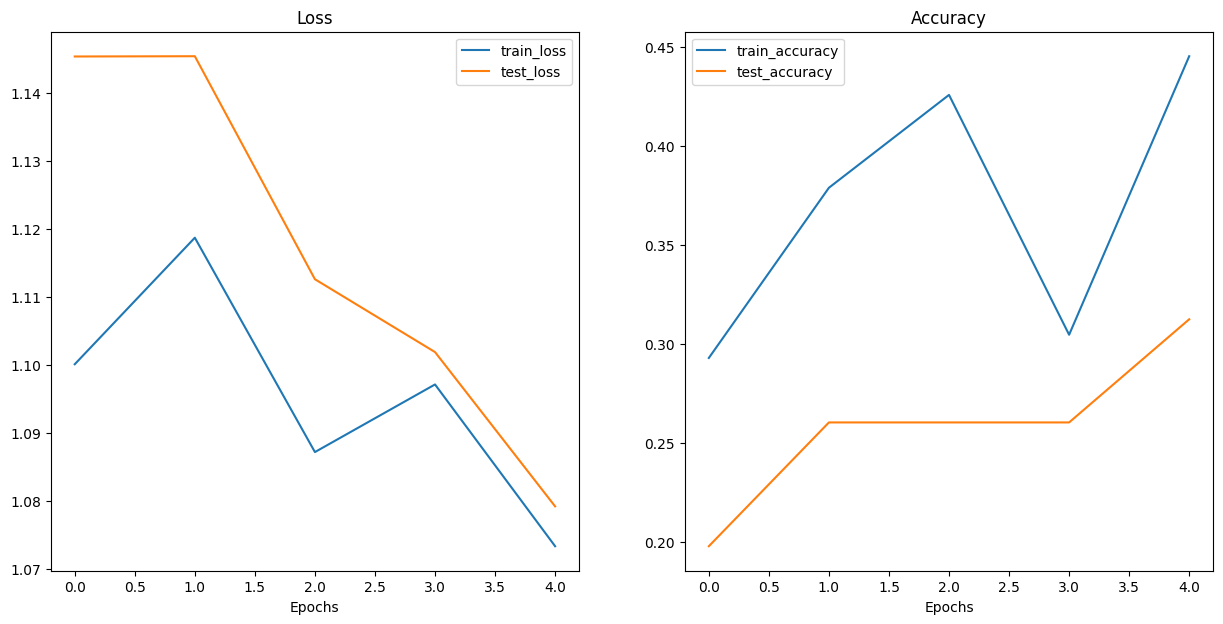

In [171]:
plot_loss_curves(model_0_results)

## 8. Ideal loss curve

One of the most helpful ways to troublehoot a model

## 9. Model 1: TinyVGG with Data augmentation



### 9.1 Create transform with data augmentation

In [172]:
train_transform_trivial =transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform_simple=transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

### 9.2 Create train and test dataset's and dataloader's with augmentation

In [173]:
train_data_aug=datasets.ImageFolder(root=train_dir,
                                    transform=train_transform_trivial,
                                    target_transform=None
                                    )
test_data_aug=datasets.ImageFolder(root=test_dir,
                                  transform=test_transform_simple
                                  )

In [174]:
train_data_aug, test_data_aug

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                ToTensor()
            ))

In [175]:
BATCH_SIZE=32

train_dataloader_aug=DataLoader(dataset=train_data_aug,
                                batch_size=BATCH_SIZE,
                                num_workers=os.cpu_count(),
                                shuffle=True)
test_dataloader_aug=DataLoader(dataset=test_data_aug,
                               batch_size=BATCH_SIZE,
                               num_workers=os.cpu_count(),
                               shuffle=False)
train_dataloader_aug, test_dataloader_aug

(<torch.utils.data.dataloader.DataLoader at 0x7fe2fcd62140>,
 <torch.utils.data.dataloader.DataLoader at 0x7fe2fcd62050>)

### 9.3 Construct and train model 1

same model with data augmentationt.

In [176]:
model_1=TinyVGG(input_shape=3,
                hidden_units=10,
                output_shapes=len(train_data_aug.classes))

In [177]:
model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

In [178]:
torch.manual_seed(42)

num_epochs=5

model_1_results=train(model=model_1,
                      train_dataloader=train_dataloader_aug,
                      test_dataloader=test_dataloader_aug,
                      optimizer=optimizer,
                      loss_fn=loss_fn)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | train loss 1.1046532690525055, train_acc: 0.2734375 | test_loss: 1.0942907730738323, test_acc:0.5104166666666666
Epoch: 1 | train loss 1.104247197508812, train_acc: 0.26953125 | test_loss: 1.0942907730738323, test_acc:0.5104166666666666
Epoch: 2 | train loss 1.105004608631134, train_acc: 0.25390625 | test_loss: 1.0942907730738323, test_acc:0.5104166666666666
Epoch: 3 | train loss 1.0986021757125854, train_acc: 0.26171875 | test_loss: 1.0942907730738323, test_acc:0.5104166666666666
Epoch: 4 | train loss 1.1049621552228928, train_acc: 0.24609375 | test_loss: 1.0942907730738323, test_acc:0.5104166666666666


In [179]:
model_1_results

{'train_loss': [1.1046532690525055,
  1.104247197508812,
  1.105004608631134,
  1.0986021757125854,
  1.1049621552228928],
 'train_acc': [0.2734375, 0.26953125, 0.25390625, 0.26171875, 0.24609375],
 'test_loss': [1.0942907730738323,
  1.0942907730738323,
  1.0942907730738323,
  1.0942907730738323,
  1.0942907730738323],
 'test_acc': [0.5104166666666666,
  0.5104166666666666,
  0.5104166666666666,
  0.5104166666666666,
  0.5104166666666666]}

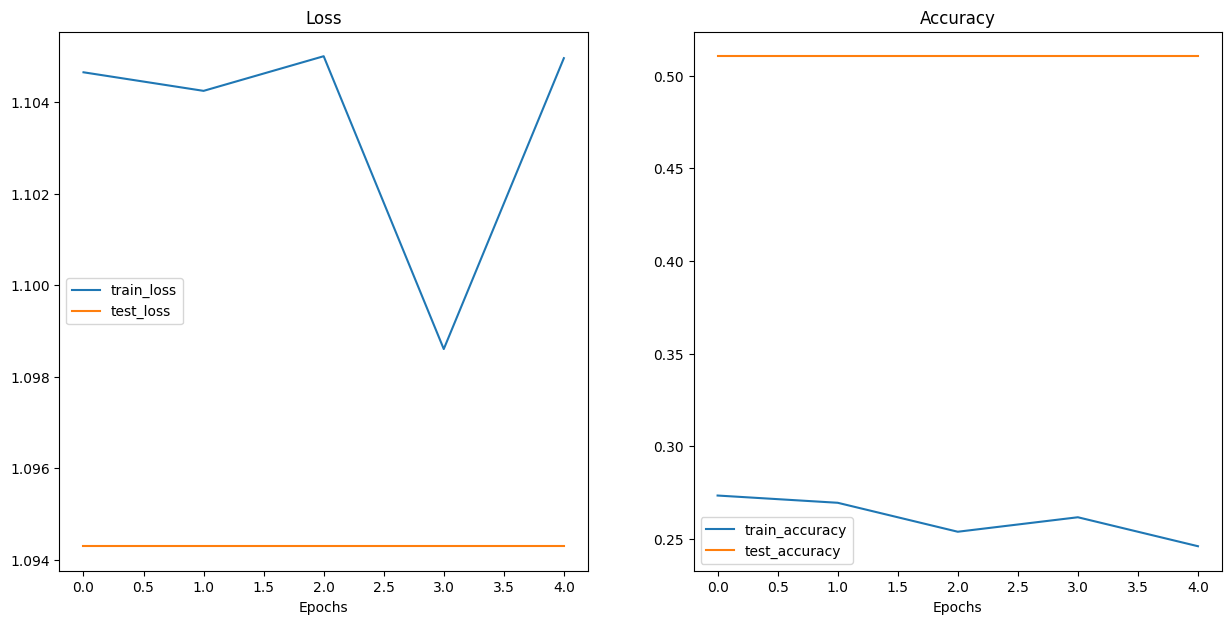

In [180]:
plot_loss_curves(model_1_results)

## 10. Compare model results

1. Hard coding
2. Pytorch+Tensorboard
3. Weights & Biases
4. MLFlow


In [181]:
import pandas as pd
model_0_df=pd.DataFrame(model_0_results)
model_1_df=pd.DataFrame(model_1_results)
model_0_df

,train_loss,train_acc,test_loss,test_acc
0,1.100090,0.292969,1.145362,0.197917
1,1.118703,0.378906,1.145402,0.260417
2,1.087171,0.425781,1.112595,0.260417
3,1.097116,0.304688,1.101880,0.260417
4,1.073320,0.445312,1.079184,0.312500


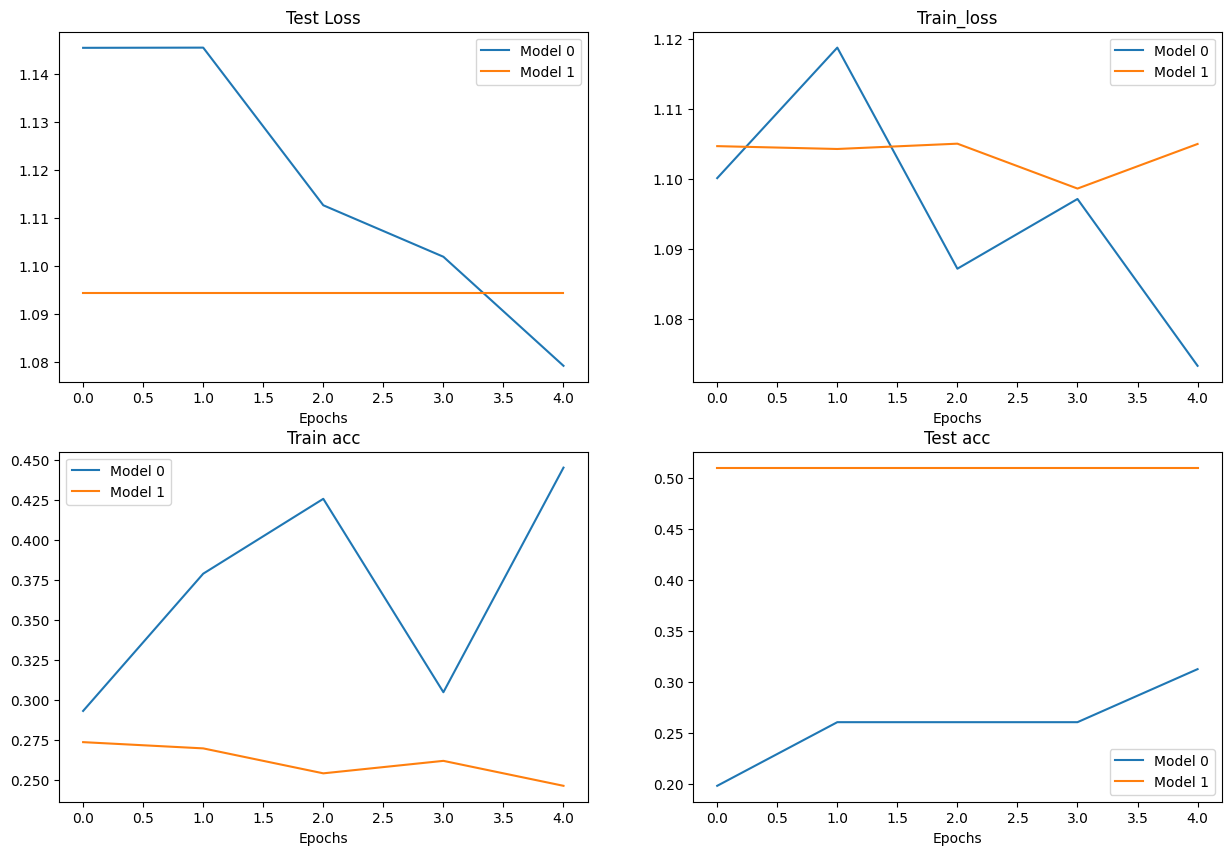

In [182]:
plt.figure(figsize=(15,10))

epochs=range(len(model_0_df))


plt.subplot(2,2,2)
plt.plot(epochs, model_0_df["train_loss"], label="Model 0")
plt.plot(epochs, model_1_df["train_loss"], label="Model 1")
plt.title("Train_loss")
plt.xlabel("Epochs")
plt.legend()

plt.subplot(2,2,3)
plt.plot(epochs, model_0_df["train_acc"], label="Model 0")
plt.plot(epochs, model_1_df["train_acc"], label="Model 1")
plt.title("Train acc")
plt.xlabel("Epochs")
plt.legend()


plt.subplot(2,2,1)
plt.plot(epochs, model_0_df["test_loss"], label="Model 0")
plt.plot(epochs, model_1_df["test_loss"], label="Model 1")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend()

plt.subplot(2,2,4)
plt.plot(epochs, model_0_df["test_acc"], label="Model 0")
plt.plot(epochs, model_1_df["test_acc"], label="Model 1")
plt.title("Test acc")
plt.xlabel("Epochs")
plt.legend()

## 11. Making a prediction on a custom image

Make prediction with new data


In [183]:
import requests

custom_image_path=data_path / "04-pizza-dad.jpeg"

if not custom_image_path.is_file():
  with open(custom_image_path, "wb") as f:
    request=requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
    print(f"Downloading {custom_image_path}...")
    f.write(request.content)
else:
  print(f"{custom_image_path} already exists, skipping downlaod")

data/04-pizza-dad.jpeg already exists, skipping downlaod


### 11.1 Loading in a custom image with Pytorch

should be in the same format as the data our model was trained on.

* In tensor form with datatype (torch.float32)
* of shape 64x64x3
* On the right device

In [184]:
import torchvision

custom_image_uint8=torchvision.io.read_image(str(custom_image_path))
print(f"custom image tensor:\n {custom_image_uint8}")
print(f" Custom image shape: {custom_image_uint8.shape}")
print(f"custom image datatype: {custom_image_uint8.dtype}")

custom image tensor:
 tensor([[[154, 173, 181,  ...,  21,  18,  14],
         [146, 165, 181,  ...,  21,  18,  15],
         [124, 146, 172,  ...,  18,  17,  15],
         ...,
         [ 72,  59,  45,  ..., 152, 150, 148],
         [ 64,  55,  41,  ..., 150, 147, 144],
         [ 64,  60,  46,  ..., 149, 146, 143]],

        [[171, 190, 193,  ...,  22,  19,  15],
         [163, 182, 193,  ...,  22,  19,  16],
         [141, 163, 184,  ...,  19,  18,  16],
         ...,
         [ 55,  42,  28,  ..., 107, 104, 103],
         [ 47,  38,  24,  ..., 108, 104, 102],
         [ 47,  43,  29,  ..., 107, 104, 101]],

        [[119, 138, 147,  ...,  17,  14,  10],
         [111, 130, 145,  ...,  17,  14,  11],
         [ 87, 111, 136,  ...,  14,  13,  11],
         ...,
         [ 35,  22,   8,  ...,  52,  52,  48],
         [ 27,  18,   4,  ...,  50,  49,  44],
         [ 27,  23,   9,  ...,  49,  46,  43]]], dtype=torch.uint8)
 Custom image shape: torch.Size([3, 4032, 3024])
custom image dat

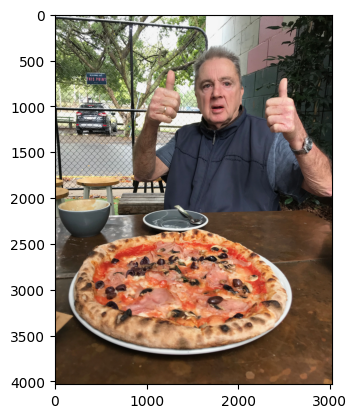

In [185]:
plt.imshow(custom_image_uint8.permute(1,2,0));

### 11.2 Making a prediction on a custom image with a trained Pytorch model

In [186]:
custom_image.shape

torch.Size([3, 4032, 3024])

In [187]:
custom_image=torchvision.io.read_image(str(custom_image_path)).type(torch.float32)/255.
custom_image.dtype

torch.float32

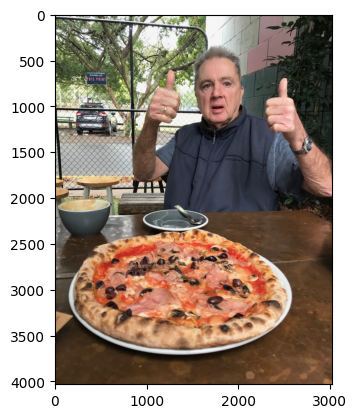

In [188]:
plt.imshow(custom_image.permute(1,2,0))

In [189]:
custom_image.permute(1,2,0).shape

torch.Size([4032, 3024, 3])

In [190]:
custom_image_transform=transforms.Compose([
    transforms.Resize(size=(64,64))
])

custom_image_transformed=custom_image_transform(custom_image)

print(f"Original shape:{custom_image.shape}")
print(f"Transformed shape:{custom_image_transformed.shape}")

Original shape:torch.Size([3, 4032, 3024])
Transformed shape:torch.Size([3, 64, 64])


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


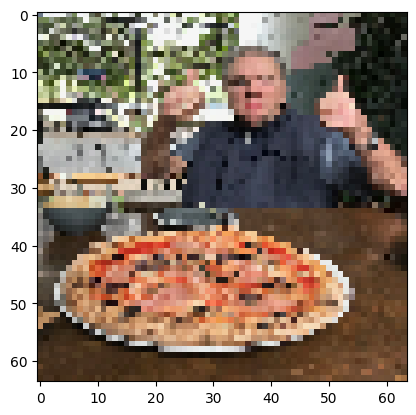

In [191]:
plt.imshow(custom_image_transformed.permute(1,2,0))

In [192]:
# Try to make a prediction on an image in uint8 format
model_1.eval()
with torch.inference_mode():
  custom_image_pred_DA=model_1(custom_image_transformed.unsqueeze(0))


custom_image_pred_DA

tensor([[-0.0102,  0.0357,  0.0397]])

In [193]:
# This will error: no batch size
model_1.eval()
with torch.inference_mode():
  custom_image_pred=model_0(custom_image_transformed.unsqueeze(0))

custom_image_pred

tensor([[ 0.0720, -0.0605, -0.0207]])

In [194]:
class_names

['pizza', 'steak', 'sushi']

Note, to make a prediction on a custom image we had to:
* Load the image and turn it into a tensor
* Make sure the image was the same datatype as the model (torch.float32)
* Make sure the image was the same shape as the data the model was trained on
* Make sure the image was on the same device as our model

In [195]:
# Converts logits to prediction probs
custom_image_pred_probs=torch.softmax(custom_image_pred, dim=1)
custom_image_pred_probs_DA=torch.softmax(custom_image_pred_DA, dim=1)
print(custom_image_pred_probs)
print(custom_image_pred_probs_DA)

tensor([[0.3588, 0.3142, 0.3270]])
tensor([[0.3228, 0.3379, 0.3393]])


In [196]:
# Convert prediction probabilities to prediction labels

custom_image_pred_labels=torch.argmax(custom_image_pred_probs, dim=1)
custom_image_pred_labels_DA=torch.argmax(custom_image_pred_probs_DA, dim=1)
print(custom_image_pred_labels)
print(custom_image_pred_labels_DA)

tensor([0])
tensor([2])


In [197]:
print(class_names[custom_image_pred_labels])
print(class_names[custom_image_pred_labels_DA])

pizza
sushi


### 11.3 Putting custom image prediction togethr: building a function

Ideal outcome:
A function where we pass an image path to and have our model predict on that image and plot the image + prediction

In [222]:
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names:List[str],
                        transform=None):
  # Load in the image
  target_image=torchvision.io.read_image(str(image_path)).type(torch.float32)

  # Devide the image pixel values by 255 to get them between [0,1]
  target_image=target_image/255.

  # Transform if necessary
  if transform:
    target_image=transform(target_image)

  model.eval()
  with torch.inference_mode():
    target_image=target_image.unsqueeze(0)
    target_image_pred=model(target_image)
    target_image_pred_probs=torch.softmax(target_image_pred, dim=1)
    target_image_class=target_image_pred_probs.argmax(dim=1)
    target=class_names[target_image_class]

    plt.imshow(target_image.squeeze().permute(1,2,0))
    plt.title(target)
    plt.axis("off")







/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


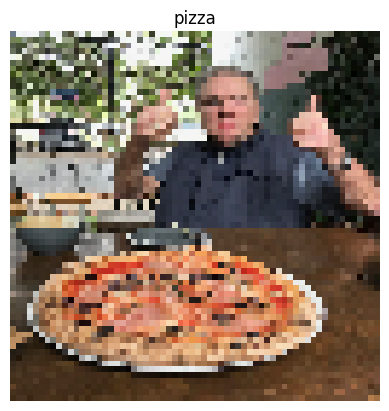

In [224]:
pred_and_plot_image(model=model_0,
                    image_path=custom_image_path,
                    class_names=class_names,
                    transform=custom_image_transform
                    )

## Exercises